In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


In [3]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

In [4]:
PREFIX = "main/ycsb-asymmetry"

index_sdf = get_index(PREFIX).withColumn("asym_ratio", F.regexp_extract("prefix", r"-(\d+)$", 1)).cache()
index_df = index_sdf\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
    .toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32",
    })

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
0,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-50,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,50
1,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-60,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,60
2,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-70,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,70
3,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-80,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,80
4,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-90,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,90
5,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-50,1.0.1022,ddr_ts,20,2000000,200,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,50
6,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-60,1.0.1022,ddr_ts,20,2000000,200,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,60
7,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-70,1.0.1022,ddr_ts,20,2000000,200,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,70
8,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-80,1.0.1022,ddr_ts,20,2000000,200,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,80
9,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-90,1.0.1022,ddr_ts,20,2000000,200,0,10,basic,100,...,1,2,100,50,2,10,1,-1,-1,90


# Throughput

In [23]:
IGNORE_CACHE = True

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_sdf.where(col("clients") == 3000)).sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)

file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-50 31744.04202360607
file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-60 31136.82771459663
file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-70 30488.585023042477
file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-80 31093.601629099234
file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-90 30813.588211880564
Saved to: main/ycsb-asymmetry/throughput.parquet


In [24]:
throughput_df

,prefix,throughput,version,config_name,duration,txns,clients,rate,sample,wl:name,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
0,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-50,31744.042024,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,...,1,2,100,50,2,10,1,-1,-1,50
1,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-60,31136.827715,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,...,1,2,100,50,2,10,1,-1,-1,60
2,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-70,30488.585023,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,...,1,2,100,50,2,10,1,-1,-1,70
3,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-80,31093.601629,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,...,1,2,100,50,2,10,1,-1,-1,80
4,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients3000-90,30813.588212,1.0.1022,ddr_ts,60,2000000,3000,0,10,basic,...,1,2,100,50,2,10,1,-1,-1,90


# Latency

In [7]:
prefixes = list(
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 200).collect()
    )
)
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_sdf = latency_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [31]:
IGNORE_CACHE = False

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_sdf.toPandas().merge(index_df, on="prefix").sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)
latency_df

,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
0,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-50,141.214464,220.992000,246.270720,274.432512,1.0.1022,ddr_ts,20,2000000,200,...,1,2,100,50,2,10,1,-1,-1,50
4,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-60,152.177408,236.368896,261.696000,274.300672,1.0.1022,ddr_ts,20,2000000,200,...,1,2,100,50,2,10,1,-1,-1,60
2,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-70,167.947520,259.860480,279.193088,314.985728,1.0.1022,ddr_ts,20,2000000,200,...,1,2,100,50,2,10,1,-1,-1,70
3,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-80,181.935616,279.586560,317.259264,356.549376,1.0.1022,ddr_ts,20,2000000,200,...,1,2,100,50,2,10,1,-1,-1,80
1,file:///home/ctring/data/slog/main/ycsb-asymmetry/ddr_ts-clients200-90,195.834368,313.755392,356.165120,400.738048,1.0.1022,ddr_ts,20,2000000,200,...,1,2,100,50,2,10,1,-1,-1,90


# Plot

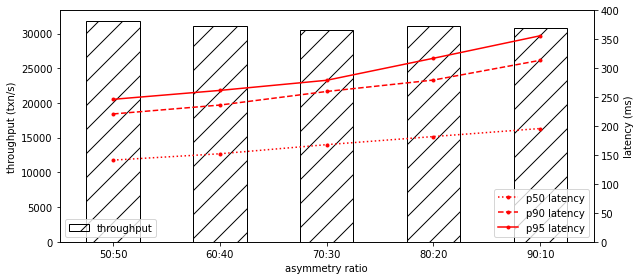

In [93]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))

throughput_df.plot.bar(ax=ax, x="asym_ratio", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("asymmetry ratio")
ax.legend(loc="lower left")
ax2 = ax.twinx()

latency_df.plot(ax=ax2, x="asym_ratio", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p90", label='p90 latency', linestyle='dashed', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p95", label='p95 latency', marker='.', color="red")
# latency_df.plot(ax=ax2, x="asym_ratio", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")
ax2.set_ylim((0, 400))
ax2.set_xticklabels(["50:50", "60:40", "70:30", "80:20", "90:10"])

ax2.legend(loc="lower right")
 
plt.tight_layout()
plt.savefig("output/asymmetry.pdf")
